# ** BREAKING THE GENOME TRIP FREQ VS SIM: keeping the #muts but using av # triplets ** 

In [1]:
from numpy.random import choice
import copy 
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import time
import timeit
import numpy as np 
import matplotlib.patches as mpatches
import json
import random

In [2]:
def base_to_mutate(DNA, current_weights, indices): 
    """
    (DNA: str, weights: Dict) -> int
    
    Will return the index of a random choice of a base that will be mutated based on probabilities given by the
    weights dictionary (i.e. the model)
    ex. "ATCGTA" --> index 3 ("G") will mutate
    """

    # NORMALIZE THE POPULATION OF WEIGHTS    
    total_freq = sum(current_weights) - current_weights[0] - current_weights[-1] # remove the start and end weight
    normalized_weights = ["error"]*len(current_weights)
    for index, value in enumerate(current_weights):
        normalized_weights[index] = value/total_freq 
    
    normalized_weights[0] = 0
    normalized_weights[-1] = 0
    # DRAW THE INDEX OF THE BASE THAT WILL BE MUTATED
    base_index = choice(indices, p=normalized_weights) 
    

    # RETURN THE INDEX
    return base_index  




In [3]:
model0 = json.load(open("../Human_mutability_model/Model_2020_12_02_genomeWide.txt"))

In [4]:
mut_dict = json.load(open("../Human_mutability_model/MutDict_2020_12_10.txt"))

In [5]:
triplet_genome_dict = json.load(open("../HumanTripletCounts/GenomeTripletCounts_2020_12_02_genomeWide.txt"))

In [8]:
triplets = []
muts_count = []
triplet_genomeCount = []
for key in mut_dict.keys(): 
    triplets.append(key)
    muts_count.append(mut_dict[key][0])
    triplet_genomeCount.append(int(triplet_genome_dict[key]))

** ok makign the broken model: same # muts but avwrage triplet # count ** 

In [10]:
average_tripletGenomeCount = np.average(triplet_genomeCount)

In [13]:
model3 = {}
for triplet,Nmut in zip(triplets, muts_count): 
    newMutability = Nmut/average_tripletGenomeCount
    into_dict = {}
    for into_trip, into_count in mut_dict[triplet][1].items(): 
        into_dict[into_trip] = int(into_count)/Nmut
    model3[triplet] = [newMutability, into_dict]

** run the sim ** 

In [23]:
#for running sumltiple at one time
n_reps = 10
dna_length = 5000 #--> total string ill be 50kbp 
prop_muts = 10

dna_dict = {}
for trial_number in (range(1,n_reps+1)): 
    

    #making the dna ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     dna_length = 5000
    DNA  = choice(["A", "T", "C", "G"], size = dna_length)
    DNA = "".join(DNA)
    DNA_initial = copy.copy(DNA)

    #triplets
    triplets = []
    for i_1 in ["A", "T", "G", "C"]: 
        for i_2 in ["A", "T", "G", "C"]: 
            for i_3 in ["A", "T", "G", "C"]: 
                triplets.append(i_1+i_2+i_3)

    #triplet-count dict 
    triplet_chosen_count_dict = {}
    triplet_into_count_dict = {}
    for triplet in triplets: 
        triplet_chosen_count_dict[triplet] = [0,0,0]  
        triplet_into_count_dict[triplet] = [0,0,0]

    #making the weights 
    current_weights = []
    for i in range(1,len(DNA)-1): 
        triplet = DNA[i-1:i+2]
        current_weights.append(model3[triplet][0])

    indices = [i for i in range(1, len(DNA)-1)]
    mut_indices = []

    #runnign the sim ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in tqdm(range(int(len(DNA)*prop_muts))):
    #     s0 = time.time()
        base_index = base_to_mutate(DNA, current_weights, indices)

    #     s1 = time.time()
    #     t1 = time.time() - s0

    #     curr_index = indices.index(base_index)
    #     current_weights = current_weights[0:curr_index -2]+current_weights[curr_index+3:]

        mut_indices.append(base_index)
    #     s2 = time.time()
    #     t2 = time.time() - s1
        #adding the count for "chosen to mutate" in coutns dict 
        c_triplet = DNA[base_index-1: base_index+2]
        c_triplet_left = DNA[base_index-2: base_index+1]
        c_triplet_right = DNA[base_index: base_index+3]
    #     s3 = time.time()
    #     t3 = time.time() - s2

        triplet_chosen_count_dict[c_triplet_left][0] += 1
        triplet_chosen_count_dict[c_triplet][1] += 1
        triplet_chosen_count_dict[c_triplet_right][2] += 1


        #accurate model INTO probability ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~OR ^ 
        curr_into_bases = []
        curr_into_bases_probs = []
        for into_base, prob in model3[c_triplet][1].items(): 
            curr_into_bases.append(into_base)
            curr_into_bases_probs.append(prob)
        mb =  choice(curr_into_bases, p = curr_into_bases_probs)[1]

        #adding the count for "mutated into thiss" in the triplet dict 
        m_triplet = c_triplet[0]+mb+c_triplet[2]
        m_triplet_left = c_triplet_left[0:2]+mb
        m_triplet_right = mb+c_triplet_right[1:3]

        triplet_into_count_dict[m_triplet_left][0] += 1 
        triplet_into_count_dict[m_triplet][1] += 1 
        triplet_into_count_dict[m_triplet_right][2] += 1 
    #     s6 = time.time()
    #     t6 = time.time() - s5

        #chanaging the dna 
        DNA = DNA[:base_index]+mb+DNA[base_index+1:]
    #     s7 = time.time()
    #     t7 = time.time() - s6

        current_weights[base_index-2]= model3[m_triplet_left][0]    
        current_weights[base_index-1]= model3[m_triplet][0]
        current_weights[base_index] = model3[m_triplet_right][0]
        
    dna_dict["Trial"+str(trial_number)] = DNA
    



 19%|█▉        | 9693/50000 [00:12<00:51, 783.61it/s]


KeyboardInterrupt: 

** getting and normalizing the simulation  triplet couts ** 

In [17]:
triplet_counts = {}
for triplet in triplets: 
    triplet_counts[triplet] = 0
    
for trial_key, dna_value in tqdm(dna_dict.items()): 
    for i in (range(1, len(dna_value)-2)):
        triplet = dna_value[i-1:i+2]
        triplet_counts[triplet] += 1

triplet_counts_list = []
for triplet in triplets: 
    triplet_counts_list.append(triplet_counts[triplet])

100%|██████████| 10/10 [00:00<00:00, 393.12it/s]


In [18]:
sum_trips_sim = sum(triplet_counts_list)

In [19]:
triplet_counts_list_norm = []
for index, element in enumerate(triplet_counts_list): 
    triplet_counts_list_norm.append(element/ sum_trips_sim)

** getting and normalizing the genome triplet counts ** 

In [20]:
triplet_genome_counts_list = []
for triplet in triplets: 
    triplet_genome_counts_list.append(int(triplet_genome_dict[triplet]))

In [21]:
sum_trips_genome = sum(triplet_genome_counts_list)

In [22]:
triplet_genome_counts_list_norm = []
for index, element in enumerate(triplet_genome_counts_list): 
    triplet_genome_counts_list_norm.append(element/ sum_trips_genome)

** plotting both together ** 

In [23]:
plt.style.use("seaborn-ticks")

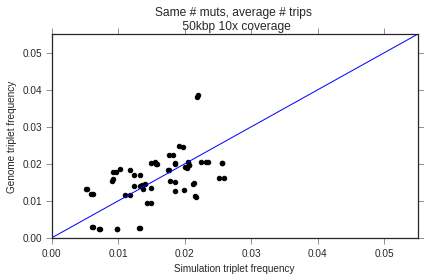

In [28]:
plt.scatter(triplet_counts_list_norm,triplet_genome_counts_list_norm, color = "black",  )
plt.plot([0,0.055], [0,0.055])
plt.xlabel("Simulation triplet frequency")
plt.ylabel("Genome triplet frequency")
plt.title("Same # muts, average # trips \n 50kbp 10x coverage")

plt.xlim((0,0.055))
plt.ylim((0,0.055))

plt.show()
# timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
# plt.tight_layout()
# plt.savefig("plots/Breakinggenome_vsSim_{t}_{l}Mbp_{p}propmuts_avNtrips.png".format(p = prop_muts, l = str(n_reps*dna_length/1000000), t = timestamp))